

### Architecture
This is the simple baseline architecture which produces the image embeddings from frozen Efficient_B0 model and simple tabular MLP is trained to produce metadata embedding. Then both are concatenated and Ridge is trained and final pawpularity are predicted
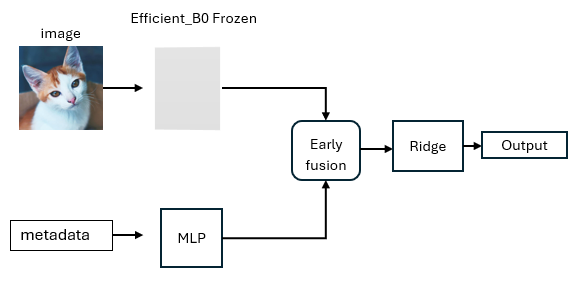

In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:

import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#  project root is on sys.path so local package `src` can be imported
sys.path.insert(0, os.path.abspath(".."))

import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error

from src.config import EXP_CONFIGS
from src.utils import set_seed, save_config
from src.data import build_transforms, ImageTabDataset
from src.models import build_vision_backbone
from src.train import extract_image_tab_features  

main_folder = ".."
data_csv = os.path.join(main_folder, "data", "train.csv")
img_folder = os.path.join(main_folder, "data", "train")
out_dir = os.path.join(main_folder, "outputs", "exp0")

df = pd.read_csv(data_csv)
cfg = EXP_CONFIGS["exp0"]
TARGET = "Pawpularity"
tab_cols = [c for c in df.columns if c not in ["Id", TARGET]]

os.makedirs(out_dir, exist_ok=True)
save_config(cfg, out_dir)
set_seed(cfg["seed"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [26]:
df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


In [27]:
#  KFold CV with frozen encoder + Ridge
backbone_name = cfg["backbone"]
img_size = cfg["img_size"]
aug_type = cfg["aug"]
alpha = cfg["ridge_alpha"]
n_splits = cfg["n_splits"]
batch_size = cfg["batch_size"]

scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[tab_cols] = scaler.fit_transform(df_scaled[tab_cols])
import joblib
joblib.dump(scaler, os.path.join(out_dir, "tab_scaler.pkl"))

kf = KFold(n_splits=n_splits, shuffle=True, random_state=cfg["seed"])
oof_pred = np.zeros(len(df))
fold_rmse = []

start = time.time()

for fold, (tr_idx, val_idx) in enumerate(kf.split(df_scaled)):
    print(f"\n=== {cfg['name']}: Fold {fold+1} (Frozen + Ridge) ===")

    train_df = df_scaled.iloc[tr_idx].reset_index(drop=True)
    val_df = df_scaled.iloc[val_idx].reset_index(drop=True)

    train_tf = build_transforms(img_size, aug_type, train=True)
    val_tf = build_transforms(img_size, aug_type, train=False)

    train_ds = ImageTabDataset(train_df, img_folder, tab_cols, train_tf)
    val_ds = ImageTabDataset(val_df, img_folder, tab_cols, val_tf)

    train_loader = DataLoader(train_ds, batch_size=batch_size,
                              shuffle=False, num_workers=4)
    val_loader = DataLoader(val_ds, batch_size=batch_size,
                            shuffle=False, num_workers=4)

    backbone = build_vision_backbone(
        backbone_name, img_size, mode="feature"
    ).to(device)
    for p in backbone.parameters():
        p.requires_grad = False

    X_img_tr, X_tab_tr, y_tr = extract_image_tab_features(train_loader, backbone, device)
    X_img_val, X_tab_val, y_val = extract_image_tab_features(val_loader, backbone, device)

    X_tr = np.concatenate([X_img_tr, X_tab_tr], axis=1)
    X_val = np.concatenate([X_img_val, X_tab_val], axis=1)

    reg = Ridge(alpha=alpha)
    reg.fit(X_tr, y_tr)
    preds = reg.predict(X_val)
    oof_pred[val_idx] = preds
    rmse = root_mean_squared_error(y_val, preds)
    fold_rmse.append(rmse)
    print(f"Fold {fold+1} RMSE: {rmse:.4f}")

    joblib.dump(reg, os.path.join(out_dir, f"ridge_fold{fold+1}.pkl"))
    torch.save(backbone.state_dict(),
               os.path.join(out_dir, f"backbone_fold{fold+1}.pt"))

elapsed = time.time() - start
print(f"\nTotal time: {int(elapsed//60)} min {int(elapsed%60)} sec")

oof_rmse = root_mean_squared_error(df[TARGET], oof_pred)
fold_rmse = np.array(fold_rmse)
print(f"OOF RMSE: {oof_rmse:.4f}")
print(f"Fold RMSEs: {fold_rmse.tolist()}  Mean={fold_rmse.mean():.4f}  Std={fold_rmse.std():.4f}")

oof_df = pd.DataFrame({
    "Id": df["Id"],
    "ytrue": df[TARGET],
    "oof_pred": oof_pred,
})
oof_df["abs_err"] = (oof_df["ytrue"] - oof_df["oof_pred"]).abs()
oof_df.to_csv(os.path.join(out_dir, "oof_detail.csv"), index=False)
oof_df.sort_values("abs_err", ascending=False).head(50).to_csv(
    os.path.join(out_dir, "top50_errors.csv"), index=False
)

np.save(os.path.join(out_dir, "oof_pred.npy"), oof_pred)
np.save(os.path.join(out_dir, "fold_rmse.npy"), fold_rmse)
with open(os.path.join(out_dir, "metrics.txt"), "w") as f:
    f.write(f"OOF_RMSE: {oof_rmse:.4f}\n")
    f.write(f"Fold_RMSE: {fold_rmse.tolist()}\nMean: {fold_rmse.mean():.4f}\nStd: {fold_rmse.std():.4f}\n")



=== Exp0_FrozenEffB0_Early_Ridge: Fold 1 (Frozen + Ridge) ===
Fold 1 RMSE: 19.8017

=== Exp0_FrozenEffB0_Early_Ridge: Fold 2 (Frozen + Ridge) ===
Fold 2 RMSE: 19.7861

=== Exp0_FrozenEffB0_Early_Ridge: Fold 3 (Frozen + Ridge) ===
Fold 3 RMSE: 19.7282

=== Exp0_FrozenEffB0_Early_Ridge: Fold 4 (Frozen + Ridge) ===
Fold 4 RMSE: 19.7702

=== Exp0_FrozenEffB0_Early_Ridge: Fold 5 (Frozen + Ridge) ===
Fold 5 RMSE: 20.0207

Total time: 1 min 17 sec
OOF RMSE: 19.8216
Fold RMSEs: [19.801685333251953, 19.78614044189453, 19.72823143005371, 19.770221710205078, 20.020660400390625]  Mean=19.8214  Std=0.1026


In [28]:
#  Inspect worst errors (optional: show images)
errors_path = os.path.join(out_dir, "top50_errors.csv")
err_df = pd.read_csv(errors_path)
err_df.head()


,Id,ytrue,oof_pred,abs_err
0,6dcb7396e06ee6a538522d2f67f017db,100,0.606342,99.393658
1,3d946559e2b4b210a06e9103b0dd72e9,5,92.764389,87.764389
2,48a66727373de4e7fa7bb3331cd9acc8,96,10.126919,85.873081
3,4c1e05895368c997fdd709bbd1ac3dae,2,86.730568,84.730568
4,d00e5d29d4ec09de1e0e0ebec41b2d03,5,87.272072,82.272072


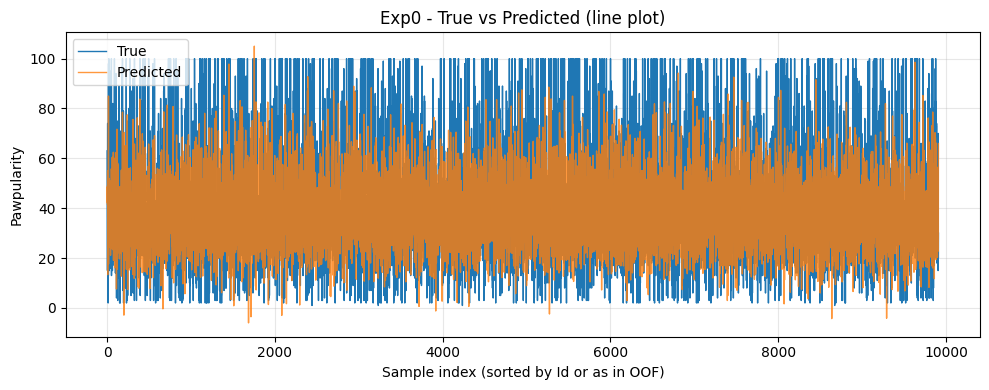

In [29]:
import os
import pandas as pd
from src.plot import (
   plot_oof_true_pred_lines,
    show_error_images_grid,
)

# Load OOF detail and top-errors
oof_df = pd.read_csv(os.path.join(out_dir, "oof_detail.csv"))
err_df = pd.read_csv(os.path.join(out_dir, "top50_errors.csv"))

# Plots
plot_oof_true_pred_lines(oof_df, title_prefix="Exp0")





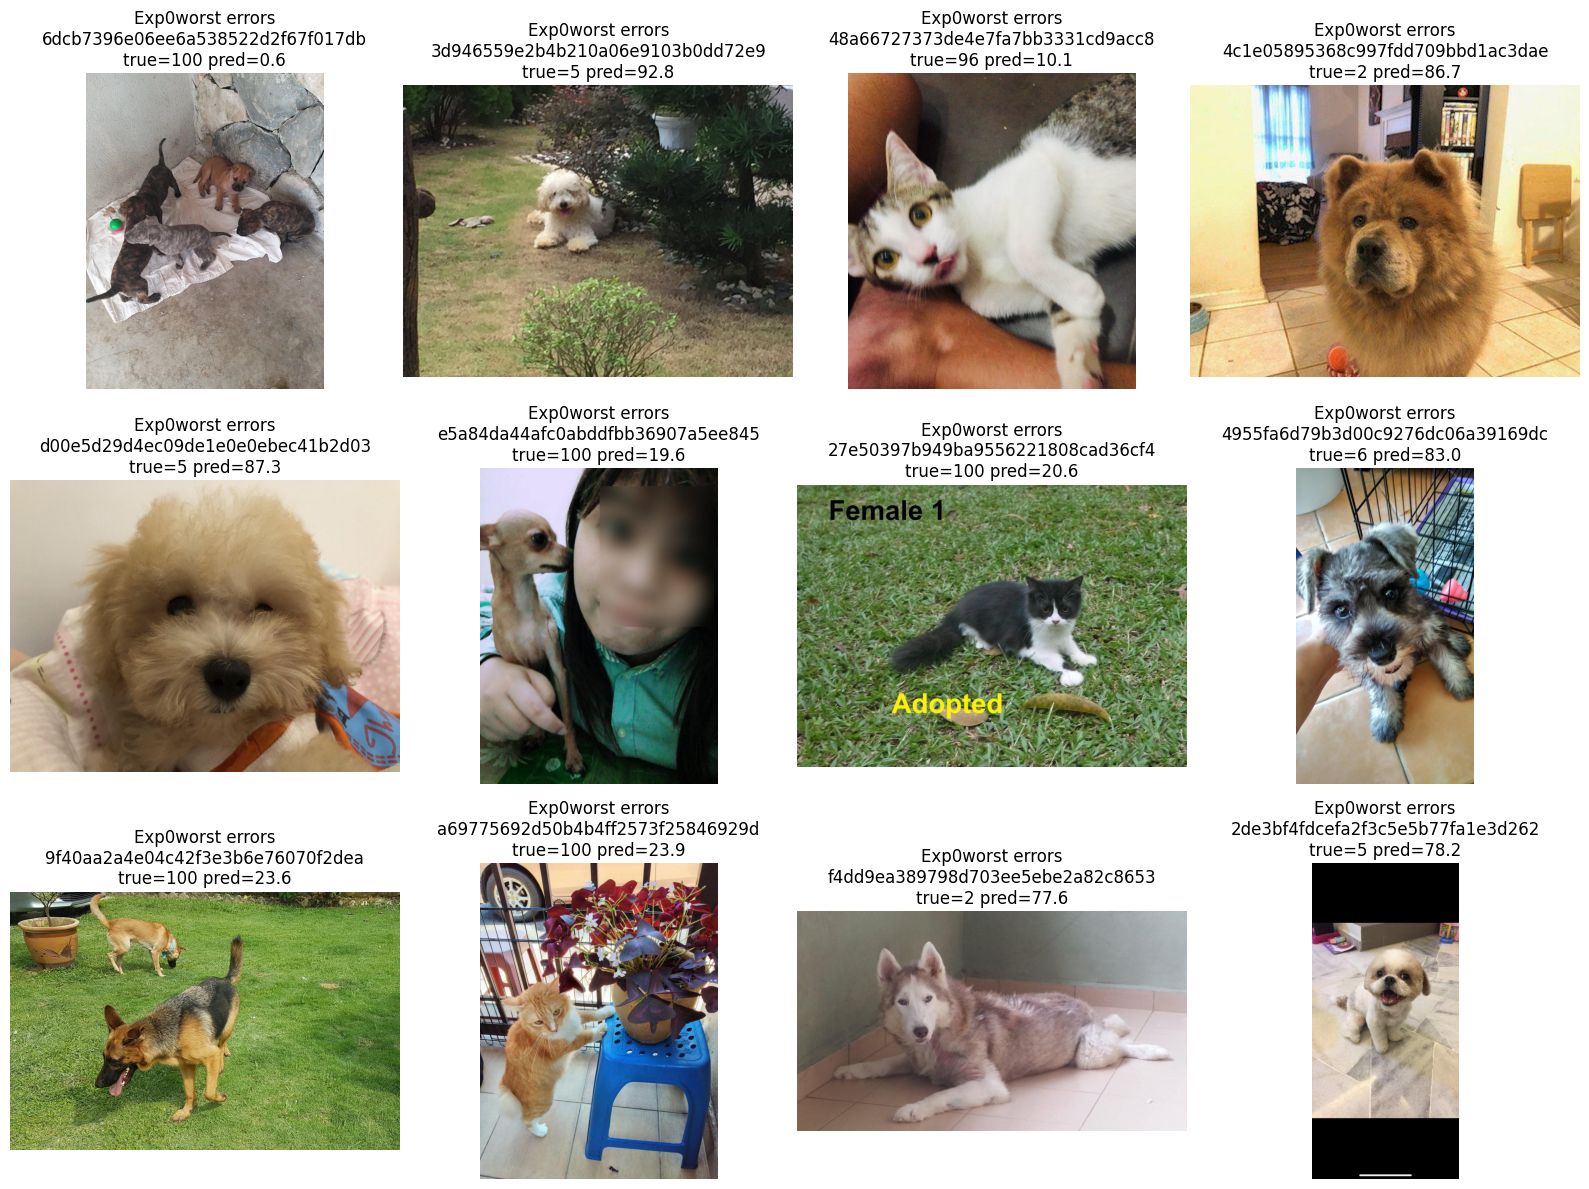

In [30]:
# Images of worst errors
show_error_images_grid(err_df, img_folder, n=12, title_prefix="Exp0worst errors")